# Inference and Reasoning with Bayesian Networks

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 2 (due: Monday, 16 May, 23:59)

Name:

Student ID:

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 20|
|Weight|20% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 5%. No assignments shall be accepted if it is later than 10 days. | 
| Coorperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |

This assignment has two parts. In the first part, you reason using basic rules of probability to estimate the probability and likelihood of different events (maximum 7 marks). In the second part, you implement two different approaches to perform inference on a given Bayesian Network (maximum 13 marks). All formulas and calculations which are not part of Python code should be written using $\LaTeX$.

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$

Setting up the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from IPython.display import display, HTML
from scipy.stats import entropy
import copy

%install_ext https://sml.forge.nicta.com.au/isml16/tutorial/tikzmagic.py

Installed tikzmagic.py. To use it, type:
  %load_ext tikzmagic


/opt/anaconda3/lib/python3.5/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


In [2]:
%load_ext tikzmagic
%matplotlib inline

## Part 1: Reasoning and Sampling with Graphical Models

### Problem setting

We are interested to predict the outcome of the election in an imaginary country, called Under Some Assumptions (USA). There are four candidates for whom the citizens can **Vote** for: Bernie, Donald, Hillary, and Ted. The citizens live in four **Region**s: north, south, east and west. We have general demographic information about the people, namely: **Gender** (male, female) and **Hand**edness (right, left). Based on surveys done by an external company, we believe that the **Region** and **Gender** affects whether the people use their **Jacket**s full time, part time or never. Surprisingly, the company told us that the **Age** of their shoes (new, worn, old) depends on how often they wear their **Jacket**s. Furthermore, the **Gender** and their preferred **Hand** affects the **Colour** of their hat (white, black). Finally, surveys say that the citizens will **Vote** based on their **Region**, **Age** of their shoes and **Colour** of their hats.

###  (1 mark) Draw the graphical model

Based on this information, write the directed graphical model using tikz. Note that tikz code has to be in its own code cell.


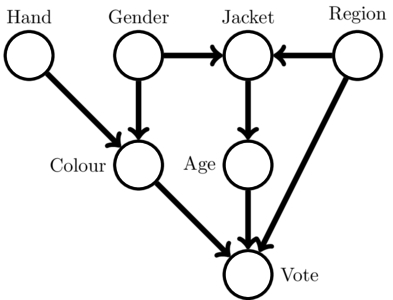

In [3]:
%%tikz --scale 2 --size 700,300 -f jpg
\tikzstyle{vertex}=[circle, draw=black, fill=white, line width=0.5mm, minimum size=25pt, inner sep=0pt]
\tikzstyle{edge} = [draw, line width=1mm, ->]

\node[vertex,label=above:{Region}] (a) at (1,0) {};
\node[vertex,label=above:{Gender}] (b) at (-1,0) {};
\node[vertex,label=above:{Jacket}] (c) at (0,0) {};
\node[vertex,label=left:{Age}] (d) at (0,-1) {};
\node[vertex,label=above:{Hand}] (e) at (-2,0) {};
\node[vertex,label=left:{Colour}] (f) at (-1,-1) {};
\node[vertex,label=right:{Vote}] (g) at (0,-2) {};


\foreach \source/ \dest in {a/c, b/c, c/d, e/f, f/g, a/g, d/g, b/f}
        \path[edge] (\source) -- (\dest);

### Conditional probability tables

After paying the survey firm some more money, they provided the following conditional probability tables.

|$p(R)$ | R=n | R=s | R=e | R=w |
|:-----:|:--:|:--:|:--:|:--:|
|marginal| 0.2 | 0.1 | 0.5 | 0.2 |

|$p(G)$ | G=m | G=f |
|:-----:|:--:|:--:|
|marginal| 0.3 | 0.7 |

|$p(H)$ | H=r | H=l |
|:-----:|:--:|:--:|
|marginal| 0.9 | 0.1 |

| $p(J|R,G)$ | R=n,G=m | R=n,G=f | R=s,G=m | R=s,G=f | R=e,G=m | R=e,G=f | R=w,G=m | R=w,G=f |
|:-----:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**J**=full $\quad$  |0.9 |0.8 |0.1 | 0.3 |0.4 |0.01| 0.02 | 0.2  |
|**J**=part $\quad$  |0.08|0.17|0.03| 0.35|0.05|0.01| 0.2  | 0.08 |
|**J**=never $\quad$ |0.02|0.03|0.87| 0.35|0.55|0.98| 0.78 | 0.72 |

| $p(A|J)$ | J=full | J=part | J=never |
|:-----:|:--:|:--:|:--:|
|**A**=new  |0.01|0.96|0.3|
|**A**=worn |0.98|0.03|0.5|
|**A**=old  |0.01|0.01|0.2|

| $p(C|G,H)$ | G=m,H=r | G=m,H=l | G=f,H=r | G=f,H=l |
|:-----:|:--:|:--:|:--:|:--:|
|**C**=black $\quad$ |0.9 |0.83 |0.17 | 0.3 |
|**C**=white $\quad$ |0.1 |0.17|0.83 | 0.7 |

The final conditional probability table is given by the matrix below. The order of the rows are alphabetical, and the order of the columns are also given below.

*Hint: The given column name format may not be the best way to code it.*

In [4]:
column_names = ['north,new,black', 'north,new,white', 'north,worn,black', 'north,worn,white', 
                'north,old,black', 'north,old,white', 'south,new,black', 'south,new,white', 
                'south,worn,black', 'south,worn,white', 'south,old,black', 'south,old,white', 
                'east,new,black', 'east,new,white', 'east,worn,black', 'east,worn,white', 
                'east,old,black', 'east,old,white', 'west,new,black', 'west,new,white', 
                'west,worn,black', 'west,worn,white', 'west,old,black', 'west,old,white']
VcRAC_vals = np.array([
        [0.1,0.1,0.4,0.02,0.2,0.1,0.1,0.04,0.2,0.1,0.1 ,0.1,0.4 ,0.1 ,0.1,0.1 ,0.1,0.04,0.3,0.2,0.1,0.3,0.34,0.35],
        [0.3,0.4,0.2,0.5 ,0.1,0.2,0.1,0.5 ,0.1,0.2,0.5 ,0.3,0.2 ,0.42,0.2,0.67,0.4,0.4 ,0.1,0.1,0.5,0.1,0.1 ,0.1],
        [0.5,0.4,0.3,0.3 ,0.5,0.6,0.6,0.3 ,0.5,0.4,0.36,0.3,0.28,0.3 ,0.4,0.1 ,0.4,0.16,0.4,0.2,0.3,0.3,0.4 ,0.5],
        [0.1,0.1,0.1,0.18,0.2,0.1,0.2,0.16,0.2,0.3,0.04,0.3,0.12,0.18,0.3,0.13,0.1,0.4 ,0.2,0.5,0.1,0.3,0.16,0.05]
    ])

### (1 mark) Encode the 7 distributions

Encode the 7 conditional probability tables in python using ```pandas.Series``` and ```pandas.DataFrame```.

Estimate the joint distribution of **Jacket**, **Region** and **Gender**. What is the the probability of full time **Jacket** usage among women in the west?

### Solution

In [5]:
# Encodes the marginal distributions as Series and the conditionals as DataFrames
def encode_dists():
    r_idx=['north', 'south','east', 'west']
    g_idx=['male','female']
    h_idx=['right','left']
    j_idx=['full','part','never']
    a_idx=['new','worn','old']
    c_idx=['black','white']
    v_idx=['Bernie','Donald','Hillary','Ted']
    
    "Marginals"
    R = pd.Series([0.2, 0.1, 0.5, 0.2], index=r_idx).sort_index()
    G = pd.Series([0.3, 0.7], index=g_idx).sort_index()
    H = pd.Series([0.9, 0.1], index=h_idx).sort_index()

    "JcRG"
    rg_idx = pd.MultiIndex.from_product([r_idx, g_idx], names=['region','gender'])
    JcRG_vals = np.array([[0.9,0.8,0.1,0.3,0.4,0.01,0.02,0.2], 
                         [0.08,0.17,0.03,0.35,0.05,0.01,0.2,0.08], 
                         [0.02,0.03,0.87,0.35,0.55,0.98,0.78,0.72]])
    JcRG = sort_idx_cols(pd.DataFrame(JcRG_vals.T, index=rg_idx, columns=j_idx))

    "AcJ"
    AcJ_vals = np.array([[0.01,0.96,0.3],[0.98,0.03,0.5],[0.01,0.01,0.2]])
    AcJ = sort_idx_cols(pd.DataFrame(AcJ_vals.T, index=j_idx, columns=a_idx))

    "CcGH"
    gh_idx = pd.MultiIndex.from_product([g_idx, h_idx], names=['gender','hand'])
    CcGH_vals = np.array([[0.9, 0.83, 0.17, 0.3],[0.1, 0.17, 0.83, 0.7]])
    CcGH = sort_idx_cols(pd.DataFrame(CcGH_vals.T, index=gh_idx, columns=c_idx))

    "VcRAC"
    rac_idx = pd.MultiIndex.from_product([r_idx, a_idx, c_idx], names=['region','age','colour'])
    VcRAC = sort_idx_cols(pd.DataFrame(VcRAC_vals.T, index=rac_idx, columns=v_idx))
    return R, G, H, JcRG, AcJ, CcGH, VcRAC

# Sorts the indexes and columns for performance
def sort_idx_cols(dist):
        return dist.sort_index(0).sort_index(1)

R, G, H, JcRG, AcJ, CcGH, VcRAC = encode_dists()

In [6]:
# Creates a multi-index from the Cartesian product of the variables in the input list
def multi_index(var_names_lst):
    return pd.MultiIndex.from_product(
        [get_idx(x) for x in var_names_lst],
        names=var_names_lst)

# Encodes a dictionary of (lexicographically) sorted variable values
def get_idx(var_name):
    idx_dict = { 
        'R': ['east', 'north', 'south', 'west'], 
        'G': ['female','male'],
        'H': ['left','right'],
        'J': ['full','never','part'],
        'A': ['new','old','worn'],
        'C': ['black','white'],
        'V': ['Bernie','Donald','Hillary','Ted'],
    }
    return idx_dict[var_name]

In [7]:
# Estimates the joint probability distribution over Region,Jacket and Gender
def est_RJG():
    rg_idx = multi_index(['R','G'])
    RJG = pd.DataFrame(np.ones((8,3)),rg_idx, columns=get_idx('J'))
    RJG.sort_index(inplace=True)
    for i in rg_idx:
            for j in get_idx('J'):
                RJG.loc[i][j] = float(JcRG.loc[i][j]*R.loc[i[0]]*G.loc[i[1]])
    return RJG
display(est_RJG())

full   never    part
R     G                             
east  female  0.0035  0.3430  0.0035
      male    0.0600  0.0825  0.0075
north female  0.1120  0.0042  0.0238
      male    0.0540  0.0012  0.0048
south female  0.0210  0.0245  0.0245
      male    0.0030  0.0261  0.0009
west  female  0.0280  0.1008  0.0112
      male    0.0012  0.0468  0.0120

** Probability of full time Jacket usage among Women in the West **
* The syntax of the question suggests that we desire the conditional P(J = full | G = female, R = west). 'Among' suggests that the sample space should be limited to women in the west.
* However, the context of the question suggests the joint P(J = full, G = female, R = west) since we have just calculated this distribution.

I provide both below

In [8]:
print('Conditional P(J = full | G = female, R = west) = ', JcRG.loc['west','female']['full'])
print('Joint P(J = full, G = female, R = west) = ', est_RJG().loc['west','female']['full'])

Conditional P(J = full | G = female, R = west) =  0.2
Joint P(J = full, G = female, R = west) =  0.028


### (3 marks) Naive sampling approach

Implement the following sampling scheme:
1. Order the nodes in the following fashion, R, G, H, J, A, C, V. Work through each node in order.
2. For the first node R, draw a sample from p(R).
3. For each subsequent node, draw a sample from the conditional distribution $p(X \,|\, parents(X))$ where $parents(X)$ are the parents of the variable $X$ in the graphical model.

Your code should be modular, with appropriate use of (well documented) functions.
### Solution

In [9]:
# Encodes the Graph as a dict and calls the recursive sample function
# Returns the sampled values for each variable as a dict
# *** Note, the values are the PARENTS of the key node, not the children ***
def sampler_driver():
    bayes_net = {
        'R': (R, None), 
        'G': (G, None), 
        'H': (H, None), 
        'J': (JcRG, ['R','G']), 
        'A': (AcJ, ['J']),
        'C': (CcGH, ['G','H']),
        'V': (VcRAC, ['R','A','C'])
    }
    samples = {
        'R': None, 
        'G': None, 
        'H': None, 
        'J': None, 
        'A': None,
        'C': None,
        'V': None,
    }
    return sample('V', samples, bayes_net)

# Recursive sampler function, implements ancestral sampling
# Recursively calls itself on each of the parents of the input node
# until the marginal node R is reached. Sampled values of parent nodes propagate
# back through the recursion until all nodes have been sampled from.
def sample(node, samples, graph):
    pars = graph[node][1]
    if pars == None:
        samples[node] = np.random.choice(graph[node][0].index, 
                                   p=graph[node][0].values)
        return samples
    else:
        for parent in pars:
            if (samples[parent] == None):
                samples[parent] = sample(parent, samples, graph)[parent]
        par_samps = tuple([samples[x] for x in pars])
        samples[node] = np.random.choice(graph[node][0].columns,
                                         p=graph[node][0].loc[par_samps])
        return samples

# Calculates n samples from the graph
def get_n_samples(n):
    sample_list = []
    for i in range(n):
        sample_list.append(sampler_driver())
    return pd.DataFrame(sample_list)

The sampler provides a sample from the joint distribution of all random variables. Why was the order in point 1. chosen? Are there other possible orders which achieve the same sampler? If yes, specify another one.
### Solution
* The order is a topological ordering of the graph, so that no node has an incoming edge from a node that appears later in the ordering. This is necessary in ancestral (naive) sampling because incoming edges represent conditions, and the conditional probabilities of later nodes can't be calculated if the nodes (variables) they are conditioned on have not been sampled from.
* Yes, a topological ordering is not unique. Alternative: G R H J A C V

Write a small test case to check that your sampler is doing the right thing by using it to verify the sum rule and product rule of probability. You can do so by drawing many samples from both sides of each rule, and show that the proportion of each state is as expected.
### Solution
We will test using variables G and H, using two sets of samples, sample_A for LHS of rules and sample_B for RHS. We first define several functions that will be used in ensuing questions to calculate distributions from data/samples.

In [10]:
# Generates a mask for the DataFrame where the vars in lst_tuples
# equal the corresponding value in lst_tuples
def gen_mask(data, lst_tuples):
    bool_list = []
    for item in lst_tuples:
        bool_list.append(data[item[0]] == item[1])
    mask = [all(tup) for tup in zip(*bool_list)]
    return mask

# Helper function to deal with single/multiple variables
def get_values(i,j, lst_cond_names):
    if type(i) != tuple:
        cond_values = [i]
    else: 
        cond_values = list(i)
    if type(j) != tuple:
        jnt_values = cond_values + [j]
    else:
        jnt_values = cond_values + list(j)
    return jnt_values, cond_values

# Empirically estimates the distribution over jnt_vars given cond_vars
def empir_cond(data, jnt_vars, cond_vars):
    jnt_idx = multi_index(jnt_vars)
    cond_idx = multi_index(cond_vars)
    empir_cond = pd.DataFrame(np.zeros((len(cond_idx),len(jnt_idx))), index=cond_idx, columns=jnt_idx)
    all_vars = cond_vars + jnt_vars
    for i in cond_idx:
        for j in jnt_idx:
            jnt_values, cond_values = get_values(i, j, cond_vars)
            mask_1 = gen_mask(data, [tup for tup in zip(cond_vars, cond_values)])
            mask_2 = gen_mask(data, [tup for tup in zip(all_vars, jnt_values)])       
            empir_cond.loc[i][j] = len(data[mask_2])/len(data[mask_1])
    return empir_cond

# Empirically estimates the marginal probability of var_name
def empir_marg(data, var_name):
    var_idx = get_idx(var_name)
    marg = pd.Series(np.zeros(len(var_idx)), var_idx)
    len_all = len(data[var_name])
    for x in var_idx:
        marg.loc[x] = len(data[data[var_name]== x])/len_all
    return marg

# Empirically estimates the joint probability of the vars in joint_vars
def empir_joint(data, joint_vars):
    joint_idx = multi_index(joint_vars)
    joint_df = pd.DataFrame(np.zeros(len(joint_idx)), joint_idx)
    len_all = len(data)
    for i in joint_idx:
        mask = gen_mask(data, [tup for tup in zip(joint_vars, list(i))])
        joint_df.loc[i] = len(data[mask])/len_all
    return joint_df

In [11]:
sample_A = get_n_samples(4000)
sample_B = get_n_samples(4000)

Product Rule: $P(G,H) = P(G | H)P(H)$

In [12]:
# Est. of joint P(G,H) from sample_A. (LHS of Product Rule)
def est_joint(sample):
    gh_idx = multi_index(['G','H'])
    GH_joint=pd.Series(np.zeros(4), gh_idx)
    for i in gh_idx:
            df = sample[['G','H']][(sample.H == i[1])]
            GH_joint[i] = len(df.G[df.G == i[0]])/len(sample)
    return GH_joint

# Est. of P(G|H)P(H) from sample_B (RHS of Product Rule)
def est_prod_RHS(sample):
    GcH = empir_cond(sample_B, ['G'],['H'])
    H = empir_marg(sample_B, 'H')
    GcH_H = GcH.T.mul(H).as_matrix().flatten()
    return pd.Series(GcH_H, multi_index(['G','H']))

print("Prod Rule LHS: P(G,H)")
display(est_joint(sample_A))
print("Prod Rule RHS: P(G|H)P(H)")
display(est_prod_RHS(sample_B))

Prod Rule LHS: P(G,H)


G       H    
female  left     0.07075
        right    0.62350
male    left     0.02675
        right    0.27900
dtype: float64

Prod Rule RHS: P(G|H)P(H)


G       H    
female  left     0.07675
        right    0.62350
male    left     0.03075
        right    0.26900
dtype: float64

Sum Rule: $P(G) = \sum_{H} P(G,H)$

In [13]:
# Est. of Sum_{H}P(G,H) from sample_A. (RHS of Sum Rule)
print("Sum Rule LHS: P(G)")
display(empir_marg(sample_A,'G'))

# Est. of marginal P(G) from sample_B. (LHS of Sum Rule)
def est_RHS_sum_rule(sample_B):
    G = pd.Series(np.zeros(2), get_idx('G'))
    for g in get_idx('G'):
        for h in get_idx('H'):
            G[g] += est_joint(sample_B)[g,h]
    return G
print("Sum Rule RHS: Sum_{H} P(G,H)")
display(est_RHS_sum_rule(sample_B))

Sum Rule LHS: P(G)


female    0.69425
male      0.30575
dtype: float64

Sum Rule RHS: Sum_{H} P(G,H)


female    0.70025
male      0.29975
dtype: float64

### (2 marks) Estimating conditional probabilities

Use your sampler above to estimate:
1. the marginal probability of $p(V)$,
2. the probability of women that vote for Hillary, $p(V=Hillary \,|\, G=female)$.

Show a plot that describes the number of samples that are needed to estimate $p(V)$ accurately.

### Solution

In [14]:
print("1. Estimate of Marginal P(V):")
display(empir_marg(sample_A, 'V'))
print("2. Est. of P(V = Hillary | G = female): ")
display(empir_cond(sample_A, ['V'], ['G']).loc['female']['Hillary'])

1. Estimate of Marginal P(V):


Bernie     0.15675
Donald     0.35375
Hillary    0.28700
Ted        0.20250
dtype: float64

2. Est. of P(V = Hillary | G = female): 


0.25063017644940583

In [ ]:
# Draws n samples to estimate the marginal probability of V
def est_V_n_samples(n):
    samples = get_n_samples(n)
    V = empir_marg(samples, 'V')
    return V

# Generates a series of estimates and variance values for P(V)
# for plotting. Each set of n samples is drawn independently
def gen_plot_data():
    V_df = []
    var_df = []
    n_s = np.arange(1,300)
    for n in n_s:
        V_est = est_V_n_samples(n)
        V_df.append(V_est)
        if n <= 10:
            var = np.var(V_df[0:n],axis=0)
            var_df.append(var)
        else:
            var_last_10 = np.var(V_df[n-10:n],axis=0)
            var_df.append(var_last_10)
    V_df = pd.DataFrame(V_df, columns=get_idx('V'))
    var_df = pd.DataFrame(var_df, columns=get_idx('V'))
    return V_df, var_df

In [ ]:
V_df, var_df = gen_plot_data()

In [ ]:
# Plots the data generated
var_plot_df = var_df.loc[0:50]
var_plot = var_plot_df.plot(kind='line')
var_plot.set_xlabel('no. of samples')
var_plot.set_ylabel('Variance of estimate of P(V)')
V_plot = V_df.plot(kind='line')
V_plot.set_xlabel('no. of samples')
V_plot.set_ylabel('P(V)')

We start with 1 sample and then increase 1 sample at a time to a maximum of 300 samples. The first plot shows the variance among the last 10 estimates of P(V), which is high early, and is < 0.01 after only 50 independent samples, though this is not an unusual result (cf. Bishop p524). The second plot shows the estimate of P(V) each time n samples are taken, which progressively stabilises (and in the limit should converge to the real P(V) if our samples truly are independent, cf. Bishop p524).

### (3 marks) Direct estimation of conditional probabilities

Write down the expression of the joint probability $p(R,G,H,J,A,C,V)$ in terms of the conditional probabilities in the graphical model.

Use the sum rule and product rule of probability to derive:
* $p(V = Donald \;\,|\, G = male)$
* $p(G = male \,|\, V = Donald)$
* the marginal probability of **Vote**s.

### Solution

Joint Probability:
$$p(R,G,H,J,A,C,V) = p(R)p(G)p(H)p(J|R,G)p(A|J)p(C|GH)p(V|R,A,C)$$
(a)
\begin{align}
p(V|G) = \frac{p(V,G)}{P(G)} &= \frac{\sum_{R,H,J,A,C}p(R,G,H,J,A,C,V)}{p(G)}\\
&= \frac{\sum_{R,H,J,A,C}p(R)p(G)p(H)p(J|R,G)p(A|J)p(C|GH)p(V|R,A,C)}{p(G)}\\
&= \sum_{R,H,J,A,C}p(R)p(H)p(J|R,G)p(A|J)p(C|GH)p(V|R,A,C)\\
&= \sum_{R}p(R)\sum_{J}p(J|R,G)\sum_{A}p(A|J)\sum_{C}p(V|R,A,C)\sum_{H}p(C|G,H)p(H)
\end{align}
Hence
\begin{align}
p(V=D|G=M)
&= \sum_{R}p(R)\sum_{J}p(J|R,G=M)\sum_{A}p(A|J)\sum_{C}p(V=D|R,A,C)\sum_{H}p(C|G=M,H)p(H)
\end{align}

(b) 
\begin{align}
p(G=M|V=D)
&= \frac{p(V=D|G=M)p(G=M)}{p(V=D)}\\
&=\frac{p(G=M)\sum_{R}p(R)\sum_{J}p(J|R,G=M)\sum_{A}p(A|J)\sum_{C}p(V=D|R,A,C)\sum_{H}p(C|G=M,H)p(H)}{p(V=D)}\\
&=\frac{p(G=M)\sum_{R}p(R)\sum_{J}p(J|R,G=M)\sum_{A}p(A|J)\sum_{C}p(V=D|R,A,C)\sum_{H}p(C|G=M,H)p(H)}{\sum_{R}p(R)\sum_{G}p(G)\sum_{J}p(J|R,G)\sum_{A}p(A|J)\sum_{C}p(V=D|R,A,C)\sum_{H}p(C|G=M,H)p(H)}\\
\end{align}


(c) 
\begin{align}
p(V) = \sum_{R,G,H,J,A,C}p(R,G,H,J,A,C,V) &= \sum_{R,G,H,J,A,C}p(R)p(G)p(H)p(J|R,G)p(A|J)p(C|GH)p(V|R,A,C) \\
&= \sum_{R}p(R)\sum_{G}p(G)\sum_{J}p(J|R,G)\sum_{A}p(A|J)\sum_{C}p(V|R,A,C)\sum_{H}p(H)p(C|G,H)
\end{align}

Using the encoding of the conditional probability tables in ```pandas.Series``` and ```pandas.DataFrame```, and your expressions above, calculate the desired conditional probability tables. Your code should be modular, with appropriate use of (well documented) functions.

In [ ]:
# Matrix multiplies the factors (conditional distributions)
# to retrieve P(V|G). Uses the Einstein summation notation to simplify
# the representation of the operations. 
# *** Not all of the intermediate results calculated are proper distributions ***
# *** They should be thought of as functions of the variables in their names ***
def VcG():
    CcG = np.einsum('cgh,h->gc', CcGH.to_panel(), H)
    CVRA = np.array([VcRAC.xs('black', level='colour').to_panel().as_matrix(),
                     VcRAC.xs('white', level='colour').to_panel().as_matrix()])
    VRAG = np.einsum('cvra,gc->vrag', CVRA, CcG)
    VRGJ = np.einsum('vrag,ja->vrgj', VRAG, AcJ)
    VcRG = np.einsum('vrgj,jrg->vrg',VRGJ,JcRG.to_panel())
    VcG = np.einsum('vrg,r->gv',VcRG,R)
    return pd.DataFrame(VcG, get_idx('G'), columns=get_idx('V'))

# Calculates P(G|V)
def GcV():
    GcV = np.einsum('gv,g,v->vg', VcG(),G,1/V_marg())
    return pd.DataFrame(GcV, get_idx('V'), columns=get_idx('G'))

# Calculates P(V)
def V_marg():
    return VcG().T.dot(G)

In [ ]:
print('p(V=D|G=M) = ')
display(VcG().loc['male']['Donald'])
print('\np(G=M|V=D) = ')
display(GcV().loc['Donald']['male'])

|$p(V | G)$ | V = Bernie | V = Donald | V = Hillary | V = Ted |
|:-----:|:--:|:--:|:--:|:--:|
|G = female | 0.133114 | 0.387251 | 0.268675 | 0.210960 |
|G = male| 0.205460 | 0.246485 | 0.358109 | 0.189947 |


|$p(V)$ | V = Bernie | V = Donald | V = Hillary | V = Ted |
|:-----:|:--:|:--:|:--:|:--:|
|marginal| 0.154818 | 0.345021 | 0.295505 | 0.204656 |


|$p(G|V)$ | G = female| G = male |
|:-----:|:--:|:--:|
| V = Bernie | 0.601867 | 0.398133 | 
| V = Donald | 0.785678 | 0.214322 | 
| V = Hillary | 0.636444 | 0.363556  |
| V = Ted | 0.721562 | 0.278438 |

### Solution

### (3 marks) Estimating structure

It turns out that the external company that we used to estimate the probabilities above did not do such a good job. There is reason to believe that the given graphical model above is wrong. However, it is believed that the true graphical model has more or less the same number of edges, and is sharing some conditional probability tables. In particular, assume that the conditional probability table for **Voting** conditioned on **Region**, **Age** and **Colour** remains the same. 

An enterprising student from the Amazing Neighbourhood University (ANU) obtained some data by polling. This data is available from [this website](https://sml.forge.nicta.com.au/isml16/assignment/poll-data.csv.gz). Use this data to identify a good graphical model.

Show:
1. The tikz image of the graphical model (this has to be in its own cell)
2. The conditional probability tables as markdown

Argue why the new graphical model that you estimated from the data is a good one.

*A majority of marks are allocated for the method of finding the graphical model.*

*** Graph Structure Algorithm *** 
* The algorithm first initialises a dict (adjacency list) representation of the graph, with keys being nodes and values being the list of (edges to) PARENTS of the key node. The edges between V and R, A, and C are added, since we are told this conditional probability table is correct. All other adjacency lists are blank.
* For every remaining pair of variables, the mean of the pairwise KL divergences between $P(A|B = b)$, and $P(A|B = b')$, for all $b, b'$. This is an efficient way of measuring the divergence (or 'distance') between P(A|B) for different values of the condition B. If this mean value is close to 0, conditioning on B has little effect. The variables are therefore concluded to be independent, and no edge is added between them.
* For each of the dependent pairs, an undirected edge is added to the graph.
* To make a principled choice regarding what 'close to 0' means, we compute the KL divergence between the empirical estimate of $P(V|RAC)$, and the given true conditional probability table (since we are told this table is correct). This gives us an estimate of the divergence we can expect to result simply from noise in the data and sampling error. We multiply this divergence by a tolerance factor to get the tolerance that will be used when KL divergences are calculated by all remaining methods. A higher tolerance factor allows for more conditional independences to be found (since two almost equal distributions will be treated equal), and thus encourages a sparser graph. A very low tolerance factor will cause the algorithm to simply return the joint simply factorised according to the product rule. This tolerance factor therefore fucntions as a regularisation parameter over the number of edges in the graph.

*** Reasoning Using Blocked Paths ***
* Next, the algorithm looks at junctions in the graph (triplets of nodes with connecting edges). If the nodes adjacent to the junction are not connected, they are conditionally independent given nothing, so the junction must be a Head-Head node, which allows the determination of the direction of the relevant edges.
* If the nodes A and C adjacent to the junction node B have a connecting edge, they are dependent given nothing (as per the earlier part of the algorithm). We therefore conditional independence of A and C given B. If A is conditionally independent of C given B, the connecting edge between A and B is removed. 

*** Assigning Direction to Remaining Undirected Edges, Testing for Cycles ***
* At this stage, the graph properties already tested entail that most edges are already directed. In fact, since no higher order conditional independences can remain for this particular graph (no remaining variables are conditioned on more than two variables), we can conclude that the direction of all remaining edges is arbitrary (because the factorisations corresponding to either choice of direction will be equivalent. That is, unless, there are cycles remaining in the graph.
* We therefore randomly assign directions to the remaining undirected edges, and test if the graph is a directed acyclic graph DAG. The algorithm terminates when the first DAG is found.

*** Evaluating the Graph ***
* We then compute the factored joint distribution by multiplying the factors corresponding to the derived graph.
* Then we take the KL divergence between this graph and the empirically estimated joint distribution. If it is sufficiently close to the tolerance calculated earlier, we conclude that this factorization accurately represents the distribution of the data.
* After running the algorithm for various tolerances near our calculated tolerance, only two graphs emerged as candidates: a sparser graph and a denser one. We computed the KL divergence between each corresponding factorisation and the empirical joint distribution, and between the two factorised joints, and found the KLs to be basically equal. This means that they both represent the underlying distribution equally well, and thus the sparser graph must capture the true conditional independences.

In [ ]:
# Generates the powerset of parents for a node, 
# size of subsets can also be specified
def powerlist(iterable, subset_size = None):
    s = list(iterable)
    plist =  list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1)))
    if subset_size != None:
        return [tup for tup in plist if len(tup) == subset_size]
    else: return [tup for tup in plist if len(tup) > 0 and len(tup) < len(s)]

# Calculates the KL divergence tolerance by comparing the empirically estimate
# of P(V|RAC) with the given true probability table 
def KL_tol(data, VcRAC):
    empir_VcRAC = empir_cond(data, ['V'], ['R','A','C'])
    KL = 0
    rac_idx = multi_index(['R','A','C'])
    KL = entropy(VcRAC, empir_VcRAC).mean()
    return KL

def prune_list(iterable, ignore_list):
    return [item for item in iterable if item not in ignore_list]

# Calculates the pairwise KL divergences between P(A|B = b) and P(A|B=b')
# for different values of the condition, to determine independence K
def pairw_KL(data, var_tup):
    cond_vals = get_idx(var_tup[1])
    cond = empir_cond(data, [var_tup[0]],[var_tup[1]])
    marg = empir_marg(data, var_tup[0])
    KL = 0
    for val in cond_vals:
        KL += entropy(marg, cond.loc[val])
    return KL/len(cond_vals)

# Calculates the pairwise KLs for all variables in the graph
def all_pairw_KL(data, var_names):
    pairs = powerlist(var_names,2)
    pairs = prune_list(pairs, list(itertools.product(['R','A','C'],['V'])))
    return dict(zip(pairs, [pairw_KL(data, pair) for pair in pairs]))

# Removes the independent pairs of variables from the list of pairs
def rm_indep_pairs(KL_d, KL_tol):
    hi_KL_d = dict(KL_d)
    for key in KL_d.keys():
        if KL_d[key] < KL_tol:
            del_d_item(hi_KL_d, key)
    return hi_KL_d

# Adds edges between dependent variables to the graph
def add_dep_edges(graph, low_KL_dict):
    for key in low_KL_dict.keys():
        graph[key[0]] = graph[key[0]] + [key[1]]
        graph[key[1]] = graph[key[1]] + [key[0]]
    return graph

def del_d_item(d, key):
    del d[key]
    return d

# Uses the blocked path properties of graphical models to
# remove edges and determine the direction of edges
def use_blocked_paths(data, undir_graph, KL_tol):
    for key in undir_graph.keys():
        junction_list = powerlist(undir_graph[key],2)
        for tup in junction_list:
            if tup[0] in undir_graph[tup[1]]:
                undir_graph = check_c_indep(data, undir_graph, key, tup, KL_tol)
            else: 
                undir_graph = make_HH(undir_graph, key, tup)
    return undir_graph

# Fixes the direction of certain edges if the junction is Head-Head
def make_HH(graph, node, parents):
    for i in range(2):
        if(node in graph[parents[i]]):
            graph[parents[i]].remove(node)
    return graph

# Checks for conditional independence between the vars in parents given node
def check_c_indep(data, graph, node, parents, KL_tol):
    if three_w_KL(data, graph, node, parents) < KL_tol:
        if parents[0] in graph[parents[1]]:
            graph[parents[1]].remove(parents[0])
        if parents[1] in graph[parents[0]]:
            graph[parents[0]].remove(parents[1])
    return graph    

# Computes the KL divergence between P(A|BC) and P(A|C) to check
# conditional independence
def three_w_KL(data, graph, node, parents):
    AcB = empir_cond(data, [parents[0]], [node])
    AcBC = empir_cond(data, [parents[0]], [node,parents[1]])
    B_vals = get_idx(node)
    C_vals = get_idx(parents[1])
    KL = 0
    BC_joint = empir_joint(data, [node, parents[1]])
    for b in B_vals:
        for c in C_vals:
            KL += entropy(AcB.loc[b], AcBC.loc[b,c]) * BC_joint.loc[b,c]
    return KL.mean()

# Removes undirected edges and checks for cycles until a DAG is found
def rm_ud_edges(ud_graph):
    ud_edges = []
    for key in ud_graph:
        for parent in ud_graph[key]:
            if key in ud_graph[parent]:
                if tuple([parent, key]) not in ud_edges:
                    ud_edges.append(tuple([key,parent]))
    graph_A = copy.deepcopy(ud_graph)
    for edge in ud_edges:
        if edge[0] in ud_graph[edge[1]]:
            graph_A[edge[1]].remove(edge[0])
    if is_DAG(graph_A):
        return graph_A
    graph_B = copy.deepcopy(ud_graph)
    for edge in ud_edges:
        if edge[1] in ud_graph[edge[0]]:
            graph_B[edge[0]].remove(edge[1])
    if is_DAG(graph_B):
        return graph_B

def is_DAG(g):
    """
    Returns True if graph is a directed acyclic graph.
    This function was taken from 
    http://codereview.stackexchange.com/questions/86021/check-if-a-directed-graph-contains-a-cycle
    at the suggestion of another student (Suraj Sasikumar) who needed a similar function
    """
    path = set()
    def visit(node):
        path.add(node)
        for parent in g[node]:
            visit(parent)
            if parent in path:
                return False
            if not visit(parent):
                return False
        path.remove(node)
        return True
    return all(visit(node) for node in g)

In [ ]:
# Computes the joint distribution from the factorisation of the denser graph found
def factor_jnt_dense(data, name_list):
    idx = multi_index(name_list)
    factor_jnt = pd.DataFrame(np.zeros(len(idx)), idx, columns=['P'])
    C = empir_marg(data, 'C')
    H = empir_marg(data, 'H')
    R = empir_marg(data, 'R')
    GcCJ = empir_cond(data, ['G'],['C','J'])
    AcR = empir_cond(data, ['A'], ['R'])
    JcC = empir_cond(data, ['J'],['C'])
    for i in idx:
        factor_jnt.loc[i]['P'] = R.loc[i[0]]*H.loc[i[2]]*C.loc[i[5]]*GcCJ.loc[i[5],i[3]][i[1]]*JcC.loc[i[5]][i[3]]*AcR.loc[i[0]][i[4]]*VcRAC.loc[i[0],i[4],i[5]][i[6]]
    return factor_jnt

# Computes the joint distribution from the factorisation of the sparser graph found
def factors_jnt_sparse(data, name_list):
    idx = multi_index(name_list)
    factor_jnt = pd.DataFrame(np.zeros(len(idx)), idx, columns=['P'])
    C = empir_marg(data, 'C')
    H = empir_marg(data, 'H')
    R = empir_marg(data, 'R')
    G = empir_marg(data, 'G')
    JcCG = empir_cond(data, ['J'],['C','G'])
    AcR = empir_cond(data, ['A'], ['R'])
    for i in idx:
        factor_jnt.loc[i]['P'] = R.loc[i[0]]*H.loc[i[2]]*G.loc[i[1]]*C.loc[i[5]]*JcCG.loc[i[5],i[1]][i[3]]*AcR.loc[i[0]][i[4]]*VcRAC.loc[i[0],i[4],i[5]][i[6]]
    return factor_jnt

# Computes the KL divergences between the factorised joints and the empirically estimated joint
def KLs_factor_jnts(data, name_list):
    jnt_dense_g = factor_jnt_dense(data, name_list)
    jnt_sparse_g = factors_jnt_sparse(data, name_list)
    empr_joint = empir_joint(data, name_list)
    KL_dense = entropy(empr_joint,jnt_dense_g)
    print("KL divergence between empirical joint and factored joint for dense graph: ", KL_dense)
    KL_sparse = entropy(empr_joint,jnt_sparse_g)
    print("KL divergence between empirical joint and factored joint for sparse graph: ", KL_sparse)
    KL_rel = entropy(jnt_dense_g,jnt_sparse_g)
    print("KL divergence between factored joints for sparse and dense graph: ", KL_rel)

In [ ]:
def read_data():
    name_list = ['R','G','H','J','A','C','V'] 
    data = pd.read_csv('poll-data.csv', names = name_list).loc[1:]
    return data, name_list

# MAIN FUNCTION FOR COMPUTING OPTIMAL GRAPH
# Optimal graph found depends on the tolerance KL_tol
def optimal_graph(data, KL_tol, name_list):
    base_graph = dict(zip(name_list, list(itertools.repeat([], len(name_list)))))
    base_graph['V'] = ['R','A','C']
    pairw_KLs = all_pairw_KL(data, name_list)
    dep_pairs = rm_indep_pairs(pairw_KLs, KL_tol)
    ud_graph = add_dep_edges(base_graph, dep_pairs)
    ud_graph = use_blocked_paths(data, ud_graph, KL_tol)
    opt_graph = rm_ud_edges(ud_graph)
    return opt_graph

# DRIVER FUNCTION: 
# Runs the optimal graph finder, and calls methods for displaying graphs and tables
# and computing the KL divergences to evaluate the graphs
def opt_graph_driver(VcRAC):
    data, name_list = read_data()
    tol = KL_tol(data,VcRAC)
    opt_g_low_edges = optimal_graph(data, tol*4, name_list)
    opt_g_hi_edges = optimal_graph(data, tol*2, name_list)
    print("Graph for low KL divergence tolerance: ")
    display(opt_g_hi_edges)
    print("Graph for high KL divergence tolerance: ")
    display(opt_g_low_edges)
    KLs_factor_jnts(data, name_list)
    print("\nWe therefore choose the sparser graph and present it and its conditional probability tables below: ")
    display(empir_cond(data, ['J'],['G','C']))
    display(empir_cond(data, ['R'],['A']))
    display(empir_marg(data, 'A'))
    display(empir_marg(data, 'G'))
    display(empir_marg(data, 'H'))
    display(empir_marg(data, 'C'))
    print('Note: the conditional table for P(V|RAC) is omitted as it remains the same.')
    return opt_g_hi_edges, opt_g_low_edges
    
opt_g_low_edges, opt_g_hi_edges = opt_graph_driver(VcRAC)

In [ ]:
%%tikz --scale 2 --size 700,300 -f jpg
\tikzstyle{vertex}=[circle, draw=black, fill=white, line width=0.5mm, minimum size=25pt, inner sep=0pt]
\tikzstyle{edge} = [draw, line width=1mm, ->]
\node[vertex,label=above:{Region}] (r) at (1,-1) {};
\node[vertex,label=above:{Gender}] (g) at (-3,-1) {};
\node[vertex,label=right:{Jacket}] (j) at (-2,-2) {};
\node[vertex,label=above:{Age}] (a) at (0,-1) {};
\node[vertex,label=above:{Hand}] (h) at (-2,-1) {};
\node[vertex,label=above:{Colour}] (c) at (-1,-1) {};
\node[vertex,label=right:{Vote}] (v) at (0,-2) {};
\foreach \source/ \dest in {r/a, c/j, r/v, c/v,a/v, g/j}
        \path[edge] (\source) -- (\dest);

### Solution

## Part 2: Analysis of algorithms

### (4 marks) Incremental EM
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Btheta}{\boldsymbol{\mathsf{\theta}}}$
$\newcommand{\Cond}{\,|\,}$

Given are $N$ independent data points $\B{x}_1,\dots,\B{x}_N$ and a Gaussian mixture model with corresponding latent variables $\B{z}_1,\dots,\B{z}_N$. As the joint distribution $p(\B{X}, \B{Z} \Cond \Btheta)$ factorises over the data points, one can develop an incremental form of EM in which only one data point is processed in each E- and M-step if the mixture component is a member of the exponential family. 

Consider a mixture of Gaussians. The update for the effective number of data points $N_k$ after having seen data point $\B{x}_m$ can be derived as
$$
  N_k^\text{new} = N_k^\text{old} + \gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})
$$

1. Define $\gamma^\text{new}(z_{mk})$.
- Prove the above given result for the update of $N_k$.
- Develop the update formulas for the other parameters of the Gaussian mixture model: 
  - mixture coefficients $\mathsf{\pi}_k$, 
  - means $\mathsf{\mu}_k$, and 
  - covariances $\mathsf{\Sigma}_k$.
- Define and explain two properties of this incremental EM algorithm which make it preferable method over batch EM.

### Solution

1. The mixture defines a complex distribution over $x_n$ in terms of a set of K simpler Gaussian distributions $(\mathbf{x_n}\lvert z_{nk} = 1)$. The latent variable $\mathbf{z_n}$ has a 1-of-K representation where, roughly speaking, $z_k$ equal to 1 if $x_n$ 'was drawn from' the kth Gaussian $(\mathbf{x_n}\lvert z_{nk} = 1)$. More precisely, $\gamma(z_{mk}) = p(z_{mk}= 1 \lvert \mathbf{x}_m)$ is the posterior probability that $z_{mk} = 1$ given $x_m$, or the 'responsibility' of the $k^{th}$ component of the mixture for 'explaining' the observation $\mathbf{x_m}$ (cf. Bishop p432). In incremental EM, the responsibility update for a single point $x_m$ is computed from the current estimates of the parameters $\mu_k^{old}$ and $\Sigma^{old}$ and the mixing coefficients $\pi^{old}$. By Bayes Rule:
\begin{align}
\gamma^{new}(z_{mk}) = \frac{p(z_{km} = 1)p(\mathbf{x_m}\lvert z_{km} = 1)}{p(\mathbf{x_m})} = \frac{\pi_k^{old} \mathcal{N}(\mathbf{x_m} \lvert \mu^{old}_k,\Sigma^{old}_k)}{\sum_{j=1}^k\pi_j^{old} \mathcal{N}(\mathbf{x_m} \lvert \mu^{old}_j,\Sigma^{old}_j)}
\end{align}
2. From Bishop 9.18 we have that
\begin{align}
N_k^{old} &= \sum_{n=1}^N \gamma^{old}(z_{nk})\\
\end{align}
Updating the responsibilities $\gamma(z_{mk})$:
\begin{align}
N_k^{new} &= \sum_{n\neq m}\big(\gamma^{old}(z_{nk})\big) + \gamma^{new}(z_{mk}) \\
&= \sum_{n=1}^N\big(\gamma^{old}(z_{nk}) \big) - \gamma^{old}(z_{mk}) + \gamma^{new}(z_{mk})) \\
&= N_k^{old} + \gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})
\end{align}


3.(i) 
\begin{align}
\pi_k^{new} = \frac{N_k^{new}}{N} &= \frac{N^{old}_k}{N}+\frac{\gamma^{new}(z_{mk})-\gamma^{old}(z_{mk})}{N}\\
&= \pi_{old}+\frac{\gamma^{new}(z_{mk})-\gamma^{old}(z_{mk})}{N}\\
\end{align}

(ii) Again from Bishop 9.18 we have the following two definitions:
\begin{align}
\mu_k^{old} &= \frac{1}{N_k^{old}}\sum_{n=1}^{N}\gamma(z_{nk})x_n\\
\end{align}
Updating the responsibilities $\gamma(z_{mk})$:
\begin{align}
\mu^{new}_k &= \frac{1}{N_k^{new}}\sum_{n=1}^{N}\gamma (z_{nk})x_n\\
&= \frac{1}{N_k^{new}}\bigg(\sum_{n\neq m}^{N}\big(\gamma^{old}(z_{nk})x_n\big) + \gamma^{new}(z_{mk})x_m\bigg)\\
&= \frac{1}{N_k^{new}}\bigg(\sum_{n=1}^{N}\big(\gamma^{old}(z_{nk})x_n\big) + \gamma^{new}(z_{mk})x_m - \gamma^{old}(z_{mk})x_m\bigg)\\
&=  \frac{N_k^{old}}{N_k^{new}}\mu^{old}_k + \frac{\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})}{N_k^{new}}x_m\\
&= \frac{N_k^{new} - \gamma_k^{new}(z_{mk}) + \gamma_k^{old}(z_{mk})}{N_k^{new}}\mu^{old}_k + \frac{\gamma^{new}
(z_{mk}) - \gamma^{old}(z_{mk})}{N_k^{new}}x_m\\
&= \mu^{old}_k - \frac{\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})}{N_k^{new}}\mu^{old}_k  + \frac{\gamma^{new}(z_{mk}) - \gamma^{old}(z_{mk})}{N_k^{new}}x_m \\
&= \mu^{old}_k - \frac{\gamma_k^{new}(z_{mk}) - \gamma_k^{old}(z_{mk})}{N_k^{new}}(x_m - \mu^{old}_k)
\end{align}

(iii) Again, from 9.18 we have that:
\begin{align}
\Sigma_k^{old} &= \frac{1}{N_k^{old}}\sum_{n=1}^{N}\gamma (z_{nk})(x_n-\mu_k^{old})(x_n-\mu_k^{old})^T \\
\end{align}
Updating the responsibilities $\gamma(z_{mk})$:
\begin{align}
\Sigma_k^{new} &= \frac{1}{N_k^{new}}\big(\sum_{n\neq m}^{N}\gamma^{old} (z_{nk})(x_n-\mu_k^{old})(x_n-\mu_k^{old})^T + \gamma^{new}(z_{mk})(x_m -\mu_k^{new})(x_m-\mu_k^{new})^T \big)\\
&= \frac{1}{N_k^{new}}\big(\sum_{n\neq m}^{N}\gamma^{old} (z_{nk})(x_n-\mu_k^{new})(x_n-\mu_k^{new})^T + \gamma^{new}(z_{mk})(x_m -\mu_k^{new})(x_m-\mu_k^{new})^T \big)\\
&= \frac{1}{N_k^{new}}\big(\sum_{n=1}^{N}\gamma^{old} (z_{nk})(x_n-\mu_k^{old})(x_n-\mu_k^{old})^T - \gamma^{old}(z_{mk})(x_m -\mu_k^{old})(x_m-\mu_k^{old})^T + \gamma^{new}(z_{mk})(x_m -\mu_k^{new})(x_m-\mu_k^{new})^T \big)\\
&= \frac{N_k^{old}}{N_k^{new}}\Sigma^{old}_k + \frac{1}{N_k^{new}}\big(\gamma^{new}(z_{mk})(x_m -\mu_k^{new})(x_m-\mu_k^{new})^T - \gamma^{old}(z_{mk})(x_m -\mu_k^{old})(x_m-\mu_k^{old})^T\big)\\
&= \Sigma^{old}_k  + \frac{1}{N_k^{new}}\big((N_k^{old}-N_k^{new})\Sigma^{old}_k + \gamma^{new}(z_{mk})(x_m -\mu_k^{new})(x_m-\mu_k^{new})^T - \gamma^{old}(z_{mk})(x_m -\mu_k^{old})(x_m-\mu_k^{old})^T\big)\\
&= \Sigma^{old}_k  + \frac{1}{N_k^{new}}\big(-(\gamma^{new}-\gamma^{old})\Sigma^{old}_k + \gamma^{new}(z_{mk})(x_m -\mu_k^{new})(x_m-\mu_k^{new})^T - \gamma^{old}(z_{mk})(x_m -\mu_k^{old})(x_m-\mu_k^{old})^T\big)\\
&= \Sigma^{old}_k  + \frac{1}{N_k^{new}}\big(\gamma^{new}(z_{mk})((x_m -\mu_k^{new})(x_m-\mu_k^{new})^T - \Sigma^{old}_k) - \gamma^{old}(z_{mk})((x_m -\mu_k^{old})(x_m-\mu_k^{old})^T- \Sigma^{old}_k)\big)\\
\end{align}

4 . *** Properties of Incremental EM ***
* If the model (for which we are trying to maximise the likelihood function) is very complex, the E step and/or the M step of the EM algorithm may constitute an intractable computatation, particularly if the number of data points is very large (cf. Bishop p455). This is because the E and M steps of the batch algorithm have time complexity dependent on the number of data points. The incremental algorithm exploits the fact that the joint distribution (over the 'complete' data set) $p(\B{X}, \B{Z} \Cond \Btheta)$ factorises over the data points, and we can compute 'partial' E and M steps by updating the responsibilities for one data point, and then doing the corresponding M step with this new information. Thus the E and M step have constant time complexity in the number of data points.
* The incremental version of EM can often converge faster than the incremental version. This is because we can get good estimates of the parameters of the Gaussians in the mixture, and of the mixing coefficients, after processing a relatively small number of data points. The batch version of the EM algorithm requires the processing of the reponsibilities for all data points before we compute an M step to update the parameters, so it will take much longer to get good estimates of the model paramters if the number of data points is very large

### (3 marks) Sampling from a piecewise exponential distribution

In the lecture we mentioned sampling from the *exponential distribution*
given by
$$
  p(y) = \lambda e^{-\lambda y}.
$$

The *piecewise exponential distribution* is defined as
$$
  p(z) = k_m \lambda_m e^{-\lambda_m (z - z_{m})} 
         \qquad \qquad  
         \widehat{z}_{m-1,m} < z \le \widehat{z}_{m,m+1}
$$
where $ \widehat{z}_{m-1, m} $ is the point of intersection of the tangent 
lines at $ z_{m-1} $ and $ z_m $,
$ \lambda_m $ is the slope of the tangent at $ z_m $ and 
$ k_m $ accounts for the corresponding offset.

(a) Using the result for sampling from a single distribution,
devise an algorithm for sampling from the piecewise 
distribution.

(b) Given a desired distribution $ p(z) $, describe precisely how the 
piecewise exponential distribution can be used to sample from this
distribution.

(c) Explain how one can use rejected samples to better 
approximate the desired distribution $ p(z) $.



### Solution

***(a) Algorithm for sampling from the piecewise distribtion:***
* First, we find the inverse of the cumulative distribution function (CDF) of our piecewise exponential distribution. The inverse of a piecewise function is also defined piecewise, as is the CDF of a piecewise distribution. Hence we need only define the inverse of the CDF piecewise. That means we can state a general form of the CDF for a point lying in the interval z_{i-1,i}, z_{i,i+1}. Our piecewise pdf is defined as follows:

$$
  p(z) = k_i \lambda_i e^{-\lambda_i (z - z_{i})} 
         \qquad \qquad  
         z_{i-1,i} < z \le z_{i,i+1}
$$

The CDF h(y) is simply the integral:
$$
h(y) = \int_{-\infty}^{y} p(z) dz
$$
which decomposes piecewise into the definite integral over all intervals less than $z_{i-1,i}, z_{i,i+1}$, and the integral from $z_{i,i+1}$ to y for the interval in which y falls:
$$
h(y) = \sum_{j<i} \int_{z_{j-1,j}}^{z_{j,j+1}} k_j \lambda_j e^{-\lambda_j (z - z_{j})}  dz + \int_{z_{i-1,i}}^{y} k_i \lambda_i e^{-\lambda_i (z - z_{i})}  dz 
         \qquad \qquad  
         z_{i-1,i} < y \le z_{i,i+1}
$$
To simplify notation as we derive the inverse, we denote the sum on the left as $C_j$, which is only dependent on the interval in which $y$ falls and is not explicitly a function of $y$ in the final expression. 
$$
h(y) = C_i + \int_{z_{i-1,i}}^{y} k_i \lambda_i e^{-\lambda_i (z - z_{i})}  dz
         \qquad \qquad  
         z_{i-1,i} < y \le z_{i,i+1}
$$
Evaluating the indefinite integral on the right yields:

$$
h(y) = C_i + D_i - k_i e^{-\lambda_i (y - z_{i})}
         \qquad \qquad  
         z_{i-1,i} < y \le z_{i,i+1}
$$

where $ D_i = k_i e^{-\lambda_i (z_{i-1,i} - z_{i})} $ which does not depend explicitly on y. Again, for simplicity, we absorb it into $C_i$, which yields:

$$
h(y) = C_i - k_i e^{-\lambda_i (y - z_{i})}
         \qquad \qquad  
         z_{i-1,i} < y \le z_{i,i+1}
$$

We now take the inverse of the CDF h(y), to get our random variable y in terms of the value of the CDF z = h(y). The inverse has a simple form similar to that of the inverse of the normal exponential distribution:

$$
y  = z_i - \frac{1}{\lambda_i}\ln{\frac{C_i - z}{k_i}}
         \qquad \qquad  
         h(z_{i-1,i}) < z \le h(z_{i,i+1})
$$

* If $z$ is sampled from the uniform distribution $\mathcal{U}(0,1)$, then the random variable $y$ will be distributed according to the piecewise exponential distribution. Hence we simply use a random number generator to sample a value of $z$ and compute the value of $y$ using the above formula for the inverse of the CDF of the piecewise exponential. $y$ will be a sample from the piecewise exponential.

** (b) Using the piecewise exponential distribution to sample from a desired distribution p(z) (cf Bishop p529) **

The piecewise exponential can be used as an envelope distribution in rejection sampling. The typical situation in which we would use rejection sampling is when it is difficult to sample directly from the desired distribution p(z), but it is easy to evaluate p(z) to within some constant multiplicative factor (a normalizing constant $Z_p$). More precisely, when it is easy to evaluate $\bar{p}(z) = Z_p p(z)$. Rejection sampling entails sampling from a simpler envelope (or proposal) distribution $q(z)$ that multiplicatively dominates the (unnormalised) desired distribution $\bar{p}(z)$.
* **Rejection Sampling in general **
    * First we sample a random number z_0 uniformly from [0,1] using a random number generator, and use the inverse of the CDF of q(z) in the normal way to sample from the distribution q(z).
    * Next, we sample a number u_0 uniformly from $[0,kq(z)]$, where k is some constant such that $kq(z) > p(z) \forall z$.
    * Now, if u_0 >  $\bar{p}(z)$ we reject the sample (hence the name).
    * The unrejected samples are uniformly distributed under the curve $\bar{p}(z)$, and so will be distributed according to the desired distribution p(z).
* ** Using the piecewise exponential as the envelope distribution **
    * The piecewise exponential is used in cases where it is difficult to find a suitable analytic form for the envelope distribution $q(z)$. In particular, if the desired distribution $p(z)$ is log concave, we can construct the envelope function piecewise as follows (cf. Bishop p 530):
    * We take a grid of points $z_i$ and evaluate $ln(\bar{p}(z_i))$, and its gradient at each gridpoint.
    * Each pair (function value and gradient value) specify the tangent to $ln(\bar{p}(z_i))$ at that point $z_i$. We compute the points where the tangents intersect, labelled  z_{i-1}, z_{i}. These define the bounds of the intervals over which our piecewise envelope distribution is defined. The tangent segments are the log of our piecewise envelope distribution.
    * Since each of these tangent segments is a straight line in log space, the envelope distribution so constructed is the piecewise exponential. 
    * We use it to perform rejection sampling as described above

** (c) Adaptive Rejection Sampling with the Piecewise exponential (cf Bishop p529) **
*  Since our envelope function is constructed piecewise, we are able to continue to refine it by defining tighter and tighter intervals, such that it hugs the desired distribution more and more as we sample. We do this in a way that is nicely integrated with the rejection sampling algorithm
* In order to reject a sample at point z_j, we must have evaluated $\bar{p}(z_j)$. We therefore need only compute the log and the log gradient at this point and we have defined a new tangent: the tangent to $\bar{p}(z_j)$ at this new gridpoint $z_j$. We then compute the intersections of this tangent with those of the adjacent gridpoints, and we have refined one of our intervals into two. The resultant function segments more closely hug $\bar{p}(z_j)$ (since in the limit, taking tangents at finer and finer gridscales will perfectly approximate the function). Thus the probability that future samples will be rejected is reduced by the adaptation of the piecewise function.